# Pretraining on unlabeled data

In this notebook we will look at the following

![test](./ThisChapter.png)

We will take (copy over) the ``GPTModel``(and all other dependencies)  we coded previously in this notebook



In [2]:
import torch
import torch.nn as nn
from numpy.f2py.rules import options
from torch.utils.data import Dataset


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        # This is new, we will add an optional Linear layer to project the output.
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in_ca = x.shape
        keys_mha = self.W_key(x)       # (b, num_tokens, d_out)
        values_mha = self.W_value(x)   # (b, num_tokens, d_out)
        queries_mha = self.W_query(x)  # (b, num_tokens, d_out)

        # d_out is same as num_heads * head_dim
        # view reshapes the tensor without changing its data, in this case we project the
        # last d_out dimension to (num_heads, head_dim)
        keys_mha = keys_mha.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, num_heads, head_dim)
        values_mha = values_mha.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, num_heads, head_dim)
        queries_mha = queries_mha.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, num_heads, head_dim)

        # To calculation the attention score, we need the last two dimensions to be num_tokens and head_dim
        # thus we need to transpose the 1st and 2nd dimensions
        queries_mha.transpose_(1, 2)  # (b, num_heads, num_tokens, head_dim)
        keys_mha.transpose_(1, 2)     # (b, num_heads, num_tokens, head_dim)
        values_mha.transpose_(1, 2)   # (b, num_heads, num_tokens, head_dim)

         # Let calculate the attention scores, this is the dot product of queries and keys
        attn_scores_mha = queries_mha @ keys_mha.transpose(-2, -1) # (b, num_heads, num_tokens, num_tokens)

        # Apply the mask, the dimensions of the attn scores are still (b, num_heads, num_tokens, num_tokens)
        #  the mask is 2D and is applied to the last two dimensions only
        attn_scores_mha.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) #(b, num_heads, num_tokens, num_tokens)
        attn_weights_mha = torch.softmax(attn_scores_mha / self.head_dim ** 0.5, dim=-1) #(b, num_heads, num_tokens, num_tokens)
        # Apply dropout to the attention weights
        attn_weights_mha = self.dropout(attn_weights_mha) # (b, num_heads, num_tokens, num_tokens)
        # attn_weights_mha @ values_mha gives (b, num_heads, num_tokens, head_dim)
        # We need to transpose the 1st and 2nd (both 0 indexed) dimensions to get (b, num_tokens, num_heads, head_dim)
        context_vecs_mha = (attn_weights_mha @ values_mha).transpose(1,2) # (b, num_tokens, num_heads, head_dim)
        # We will reshape the context vectors back to (b, num_tokens, d_out) where d_out = num_heads * head_dim
        context_vecs_mha = context_vecs_mha.contiguous().view(b, num_tokens, self.d_out) # (b, num_tokens, d_out)
        # Finally we will project the output using the out_proj layer
        context_vecs_mha = self.out_proj(context_vecs_mha)
        return context_vecs_mha


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean_batch = torch.mean(x, dim=-1, keepdim=True)
        # unbiased=False means we do not use Bessel's correction, that is, we divide by N instead of N-1 (basel's correction)
        var_batch = torch.var(x, dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean_batch) / torch.sqrt(var_batch + self.eps)
        return norm_x * self.scale + self.shift


class FeedForward(nn.Module):
    def __init__(self, cfg, hidden_layer_dim_factor = 4):
        super().__init__()
        emb_dim = cfg["emb_dim"]
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, hidden_layer_dim_factor * emb_dim),
            GELU(),
            nn.Linear(hidden_layer_dim_factor * emb_dim, emb_dim)
        )

    def forward(self, in_batch):
        return self.layers(in_batch)

class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.dropout_shortcut = nn.Dropout(cfg["drop_rate"])
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.ff = FeedForward(cfg)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut
        return x


class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        return self.out_head(x)

Below we will instantiate the GPT model with the configuration of the smallest GPT-2 model (124M parameters), however we will reduce the context length to 256 for faster training. Additionally we will define two methods ``text_to_token_ids`` and ``token_ids_to_text``

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # we will use a smaller context length for faster training, original is 1024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featu

In [4]:
import tiktoken

def generate_text_simple(model, idx,
                          max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # Take the context_size tokens to predict the next token
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():  # No need to track gradients
            logits = model(idx_cond) # (batch_size, context_size, vocab_size)
        # Take the last generated token for this is the next token
        logits = logits[:, -1, :] # (batch_size, vocab_size)
        probs = torch.softmax(logits, dim=-1) # (batch_size, vocab_size)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True) # (batch_size, 1)
        idx = torch.cat((idx, idx_next), dim=-1) # (batch_size, current_seq_len + 1)
    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0)  # Add batch dimension

def token_ids_to_text(token_ids, tokenizer):
    token_ids = token_ids.squeeze(0).tolist()  # Remove batch dimension and convert to list
    return tokenizer.decode(token_ids)

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
    )
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


We can see that the output is not very meaningful, this is because the model is not trained yet. However all our required components are in place.

We will next look at loss metric for the generated output

### Calculating the text generation loss

![test](./TextGenerationSummary.png)


In [5]:
import tiktoken
import torch

input_text1 = "every effort moves"
input_text2 = "I really like"

expected_output_text1 = " effort moves you"
expected_output_text2 = " really like chocolate"

tokenizer = tiktoken.get_encoding("gpt2")
inputs = torch.vstack([text_to_token_ids(input_text1, tokenizer), text_to_token_ids(input_text2, tokenizer)])
print(f"Input token ids are:\n{inputs}")

targets = torch.vstack([text_to_token_ids(expected_output_text1, tokenizer), text_to_token_ids(expected_output_text2, tokenizer)])
print(f"Output token ids are:\n{targets}")


Input token ids are:
tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])
Output token ids are:
tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


Lets feed the inputs to the model and get the logits

In [6]:
with torch.no_grad():
    logits = model(inputs)
print(f"Logits shape: {logits.shape}")
probas = torch.softmax(logits, dim=-1)
print(f"Probs shape: {probas.shape}")

Logits shape: torch.Size([2, 3, 50257])
Probs shape: torch.Size([2, 3, 50257])


There are 2 batches, each with 3 tokens and each token as a probability distribution over the vocabulary of size 50257. What we need is the maximum probability for each of these 3 tokens in 2 batches.

Notice how we retain the third dimension by using ``keepdim=True``, if this wasn't provided the the result would have been of shape (2, 3) instead of (2, 3, 1)

In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f"token_ids are {token_ids} \n\nand has shape {token_ids.shape}")

token_ids are tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]]) 

and has shape torch.Size([2, 3, 1])


Lets decode and print thiese generated tokens, notice how the generated tokens are not the expected ones. We now need a loss function to measure how far off we are from the expected output. The goal is to increase the softmax probability of the expected output tokens.

With a vocabulary size of 50257, the chance probability of getting the correct token is 1/50257 = 0.0000199, this is very low.

In [8]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Remember target is what we expect the model to output. Lets look at the probabilities of these expected tokens in the generated probabilities.

probs has shape (2, 3, 50257) and target has shape (2, 3), our goal while training is to increase the probabilities of these expected tokens relative to other tokens.

In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, torch.arange(targets.shape[1]), targets[text_idx]]
text_idx = 1
target_probas_2 = probas[text_idx, torch.arange(targets.shape[1]), targets[text_idx]]
print("Text 1:", target_probas_1)
print("Text 2:", target_probas_2)


Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


We will next calculate the negative log likelihood loss (NLLLoss) which is commonly used for classification problems

![Test](./NLL.png)

In [10]:
# Flatten and compute the log probabilities
log_probas = torch.log(torch.cat([target_probas_1, target_probas_2]))
print(log_probas)
#Compute the average negative log likelihood loss
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
# We always minimise the loss, thus we take the negative, goal is to make this log_probas as close to 0 as possible
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)


tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)
tensor(10.7940)


Pytorch has a built in in ``cross_entropy`` loss function which combines the log softmax and ``NLLLoss`` in one function. We will use this to calculate the loss, recall ``logits`` are the raw outputs of the model before applying softmax

We will flatten the first two dimensions of the logits

In [11]:
print(f"Logits shape is {logits.shape}")
print(f"Targets shape is {targets.shape}")
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross entropy loss is:", loss)
print("Perplexity: ",torch.exp(loss))

Logits shape is torch.Size([2, 3, 50257])
Targets shape is torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Cross entropy loss is: tensor(10.7940)
Perplexity:  tensor(48725.8203)


Perplexity: A common metric for evaluating language models is perplexity, which is the exponentiation of the cross-entropy loss. It provides a measure of how well the model predicts a sample. A lower perplexity indicates a better predictive model. in above case of ``10.790`` perplexity is ``torch.exp(10.7940) = 48725.8203`` which means that the model is unsure of which token to predict next among 48725 tokens, this is close to the chance probability of 50257 tokens

Next we will prepare the dataset to train our small model

In [12]:
file_path = "./data/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


The dataloaders can be visualized as below

![test](./Dataloaders.png)

In [13]:
# Recreate the same data loaders we implemented in chapter 2

from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, stride, max_length):
        self.input_ids = []
        self.target_ids = []
        tokens = tokenizer.encode(text)
        for i in range(0, len(tokens) - max_length - 1, stride):
            input_id = tokens[i: i + max_length]
            target_id = tokens[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_id))
            self.target_ids.append(torch.tensor(target_id))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(text, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    return DataLoader(dataset=GPTDataset(text=text, tokenizer=tokenizer, stride=stride, max_length=max_length),
                      batch_size=batch_size,
                      drop_last=drop_last,
                      num_workers=num_workers,
                      shuffle=shuffle)

In [14]:
# Split data in train and validation set and create two data loaders
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)



Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Let us now implement the ``cross_entropy`` loss function for our given batch data and then the ``cross_entropy`` for the loader

In [15]:
import torch.nn as nn
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device) # shape (batch_size, seq_len)
    target_batch = target_batch.to(device) # shape (batch_size, seq_len)
    logits = model(input_batch) # Generates (logits) of shape (batch_size, seq_len, vocab_size)
    return nn.functional.cross_entropy(
                logits.flatten(0, 1),   # shape (batch_size * seq_len, vocab_size)
                target_batch.flatten()) # shape (batch_size * seq_len)

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    else:
        num_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                total_loss += calc_loss_batch(input_batch, target_batch, model, device).item()
            else:
                break
        return total_loss / num_batches

Lets apply this to test on a model without training

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Train loss:", train_loss)
print("Val loss:", val_loss)


Using device: mps
Train loss: 10.987583372328016
Val loss: 10.98110580444336


### Train an LLM

With all the nuts and bolts in place we will now train our LLM

In [17]:
# First define a method that evaluates the model on both train and validation set and returns the training and validation set losses
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
                     model=model, idx=encoded,
                     max_new_tokens=50, context_size=context_size
                    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

# Next we will define a simple training loop
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            global_step += 1
            tokens_seen += input_batch.numel()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, step {global_step:06d}: "
                      f"train loss {train_loss:.3f}, val loss {val_loss:.3f}, "
                      f"tokens seen {tokens_seen}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

Now lets initialize and start the training loop

In [18]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW( model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Epoch 1, step 000000: train loss 9.817, val loss 9.924, tokens seen 512
Epoch 1, step 000005: train loss 8.066, val loss 8.332, tokens seen 3072
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2, step 000010: train loss 6.619, val loss 7.042, tokens seen 5632
Epoch 2, step 000015: train loss 6.046, val loss 6.596, tokens seen 8192
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Epoch 3, step 000020: train loss 5.524, val loss 6.508, tokens seen 10752
Epoch 3, step 000025: train loss 5.369, val loss 6.378, tokens seen 13312
Every effort moves you, and to the of the of the picture. Gis.                                     
Epoch 4, step 000030: train loss 4.830, val loss 6.263, tokens seen 15872
Epoch 4, step 000035: train loss 4.586, val loss 6.285, tokens seen 18432
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been th

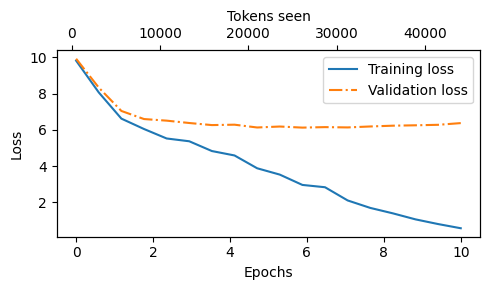

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


Once we get past second epoch we can see that the model is able to generate meaningful text. The training and validation losses are also decreasing, indicating that the model is learning. But after epoch 2, validation loss starts to increase, indicating overfitting. This is expected as we are training a large model on a small dataset.

Lets put the model back on cpu and run some sample text generation. Also, we will look at a concept called temperature scaling

In [20]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [21]:
# Lets consider this vocab again
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
# We expect the index 3 (forward) to have the highest probability
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

# If we repeat this experiment 100 times, each time the output will be the same
for _ in range(100):
    next_token_id = torch.argmax(probas).item()
    assert next_token_id == 3

forward


|Let's first look at what multinomial sampling is


In [22]:
import torch
from collections import Counter
# Define probabilities for 4 categories, image this is a 4 faced die with each face has a different probability
weights = torch.tensor([0.1, 0.2, 0.3, 0.4])

# Draw 100,000 samples from this distribution with replacement
samples_drawn = torch.multinomial(weights, 100000, replacement=True).tolist()
counts_by_face = Counter(samples_drawn)
print("Counts by face:")
for face, count in sorted(counts_by_face.items()):
    print(f"\tFace {face}: {count/len(samples_drawn):.2f}")
# We see the simulated probabilities are close to the original weights

Counts by face:
	Face 0: 0.10
	Face 1: 0.20
	Face 2: 0.30
	Face 3: 0.40


Now that we saw what multinomial sampling is, what we do next is use the probabilities of the next sample token and use multinomial sampling to select the next token. This will add some randomness unlike the previous approach where we used ``argmax`` which deterministically selected the next token with the highest probability.

We now know the probability of selection is directly proportional to the weight of each token.

In [23]:
def print_sampled_token(probas):
    torch.manual_seed(123)
    samples = torch.tensor([torch.multinomial(probas, num_samples = 1) for _ in range(1000)])
    sampled_ids = torch.bincount(samples)
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_token(probas)

# While forward is still most likely token, the other tokens also get selected sometimes
# in the same proportion as their probabilities

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


We will use an additional parameter temperature to control the randomness of the sampling. A higher temperature will make the distribution more uniform, while a lower temperature will make the distribution more peaked.

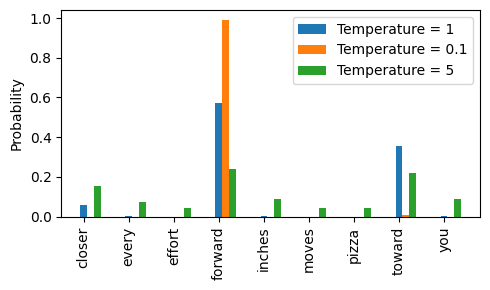

In [24]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


As we see above, when the temperature is 0.1 (low), the distribution is very peaked, meaning the model is very confident about its prediction with "forward" predicted almost always. When the temperature is 5 (high), the distribution is more uniform, meaning the model is less confident about its prediction.


TODO: Ex 5.1

We will now look at Top-k sampling

### Top-k Sampling

By increasing the temperature, we make the distribution more uniform, but this can lead to selecting very low probability tokens which may not make sense in the context. To avoid this, we can use Top-k sampling, where we only consider the top k tokens with the highest probabilities and set the rest to zero. This way, we limit the selection to a smaller set of likely tokens.

Following image summarizes this idea.

![Test](./Top-k.png)


In [25]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)
# Following line is more memory efficient but it modifies the original next_token_logits tensor
#next_token_logits[next_token_logits < top_logits[-1]] = torch.tensor(float('-inf'))

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)

print(new_logits)
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)


Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Now we will modify the ``generate`` function to include the temperature and top-k sampling


In [26]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)   # (b, context_size, vocab_size)
        logits = logits[:, -1, :]      # (b, vocab_size)

        if top_k is not None:
            top_k_logits, _ = torch.topk(logits, top_k)  # (b, top_k)
            min_val = top_k_logits[:, -1]                # (b,)
            logits[logits < min_val] = torch.tensor(float('-inf')).to(logits.device)
            #logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
        if temperature > 0:
            probs = torch.softmax(logits / temperature, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break
        else:
            idx = torch.cat((idx, idx_next), dim=-1)

    return idx


In [27]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," she down." For Mrs. Gisburn! The women had


TODO: Look at Ex 5.2 and 5.3

## Loading and saving model weights in PyTorch

Now we will not train the model from scratch, instead we will load the weights of a pretrained model.

First we will simply save the existing model and optimizer weights in a ``.pth`` file. This is the file for PyTorch format

In [28]:
torch.save({
 "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
}, "model_and_optimizer.pth")


In [29]:
checkpoint = torch.load("model_and_optimizer.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
#Lets test the previously generated output
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," she down." For Mrs. Gisburn! The women had


In [30]:
# Download the Python code that will download the GPT2 weights
import requests
import os
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
if not os.path.exists(filename):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

In [34]:
import gpt_download
import importlib
importlib.reload(gpt_download)
settings, params = gpt_download.download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 77.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 890kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 74.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:16<00:00, 3.65MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.32MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 504kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 500kiB/s]  


In [35]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
